# Day 25 – Overfitting Prevention
### Reliable Models with Dropout and Early Stopping

Today we’ll make our neural network more **robust and production-ready** by preventing overfitting using **Dropout** and **Early Stopping**.

#### Goals:
- Observe overfitting on a simple dataset
- Apply **Dropout** to regularize learning
- Implement **Early Stopping** to prevent unnecessary training
- Compare performance and loss curves

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Generate and Preprocess Dataset

In [2]:
X, y = make_moons(n_samples=1200, noise=0.25, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## 2. Define MLP with Dropout

In [3]:
class MLP_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(8, 1)
        self.out = nn.Sigmoid()
    
    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.out(self.fc3(x))
        return x

## 3. Early Stopping Utility

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## 4. Training Loop with Dropout + Early Stopping

In [5]:
model = MLP_Dropout(dropout_rate=0.3)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=10)

for epoch in range(100):
    # Train
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()

    train_losses.append(loss.item())
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1: Train Loss = 0.6872 | Val Loss = 0.6837
Epoch 2: Train Loss = 0.6822 | Val Loss = 0.6746
Epoch 3: Train Loss = 0.6750 | Val Loss = 0.6644
Epoch 4: Train Loss = 0.6643 | Val Loss = 0.6526
Epoch 5: Train Loss = 0.6563 | Val Loss = 0.6388
Epoch 6: Train Loss = 0.6433 | Val Loss = 0.6237
Epoch 7: Train Loss = 0.6298 | Val Loss = 0.6072
Epoch 8: Train Loss = 0.6191 | Val Loss = 0.5896
Epoch 9: Train Loss = 0.6051 | Val Loss = 0.5711
Epoch 10: Train Loss = 0.5931 | Val Loss = 0.5518
Epoch 11: Train Loss = 0.5683 | Val Loss = 0.5320
Epoch 12: Train Loss = 0.5605 | Val Loss = 0.5119
Epoch 13: Train Loss = 0.5434 | Val Loss = 0.4916
Epoch 14: Train Loss = 0.5244 | Val Loss = 0.4714
Epoch 15: Train Loss = 0.5005 | Val Loss = 0.4515
Epoch 16: Train Loss = 0.4930 | Val Loss = 0.4321
Epoch 17: Train Loss = 0.4799 | Val Loss = 0.4133
Epoch 18: Train Loss = 0.4659 | Val Loss = 0.3953
Epoch 19: Train Loss = 0.4489 | Val Loss = 0.3781
Epoch 20: Train Loss = 0.4377 | Val Loss = 0.3620
Epoch 21:

## 5. Plot Train vs Validation Loss

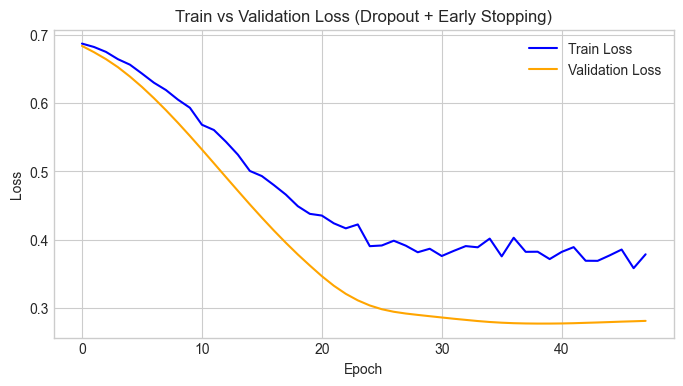

In [6]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Dropout + Early Stopping)')
plt.legend()
plt.show()

## 6. Evaluate on Test Data

In [7]:
model.eval()
with torch.no_grad():
    preds = (model(X_test) > 0.5).float()
acc = (preds.eq(y_test).sum() / y_test.shape[0]).item()
print(f'Test Accuracy: {acc*100:.2f}%')

Test Accuracy: 85.42%


## ✅ Summary
- Implemented **Dropout** to reduce overfitting.
- Added **Early Stopping** to prevent wasted training.
- Visualized training vs validation losses.
- Achieved a more generalizable model (less overfit, better stability).

**Deliverable:** `day25_overfitting_prevention.ipynb`